Churn Tutorial - Exploratory Data Analysis
Date: July 19, 2017
Author: https://github.com/beilmanmich

In [1]:
import sys
print(sys.version)

2.7.13 |Anaconda custom (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [ ]:
####### ADD BLANKET IMPORT STATEMENT ONCE FINAL!! #######

In [ ]:
###### ADD CONTENTS SECTION ONCE FINAL!! #######

# Churn Rate Introduction

"Churn Rate" is a business term describing the rate at which customers leave or cease paying for a product or service. It's a critical figure in many businesses, as it's often the case that acquiring new customers is a lot more costly than retaining existing ones (in some cases, 5 to 20 times more expensive).

Understanding what keeps customers engaged, therefore, is incredibly valuable, as it is a logical foundation from which to develop retention strategies and roll out operational practices aimed to keep customers from walking out the door. Consequently, there's growing interest among companies to develop better churn-detection techniques, leading many to look to data mining and machine learning for new and creative approaches.

Predicting churn is particularly important for businesses w/ subscription models such as cell phone, cable, or merchant credit card processing plans. But modeling churn has wide reaching applications in many domains. For example, casinos have used predictive models to predict ideal room conditions for keeping patrons at the blackjack table and when to reward unlucky gamblers with front row seats to Celine Dion. Similarly, airlines may offer first class upgrades to complaining customers. The list goes on.
Wait, don't go!

So what are some of ops strategies that companies employ to prevent churn? Well, reducing churn, it turns out, often requires non-trivial resources. Specialized retention teams are common in many industries and exist expressly to call down lists of at-risk customers to plead for their continued business.

# Marketing Examples

![alt text](Starbucks.png "Starbucks Example")
![alt text](RunKeeper.png "RunKeeper Example")
![alt text](PinkBerry.png "PinkBerry Example")

Organizing and running such teams is tough. From an ops perspective, cross-geographic teams must be well organized and trained to respond to a huge spectrum of customer complaints. Customers must be accurately targeted based on churn-risk, and retention treatments must be well-conceived and correspond reasonably to match expected customer value to ensure the economics make sense. Spending $1,000 on someone who wasn't about to leave can get expensive pretty quickly.

Within this frame of mind, efficiently dealing with turnover is an exercise of distinguishing who is likely to churn from who is not using the data at our disposal. The remainder of this post will explore a simple case study to show how Python and its scientific libraries can be used to predict churn and how you might deploy such a solution within operations to guide a retention team.

# The Dataset

The data set we'll be using is a longstanding telecom customer data set sourced from SGI's archived clone of the UCI ML database. You can download the data in *.csv* or *.all* formats here: https://www.sgi.com/tech/mlc/db/ ; variable descriptions can be referenced here: https://www.sgi.com/tech/mlc/db/churn.names 

The data is straightforward. Each row represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

## Part 1.1: Understand the Raw Dataset

In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
# display.max_columns, default is 20, None means unlimited.
pd.set_option('display.max_columns', 30)

churn_df = pd.read_csv('churn.all',header='infer')

Now that our data is imported, let's take a quick look.

In [7]:
churn_df.head()

,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,False.
0,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
1,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
2,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
3,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
4,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False.


We see that column headings aren't included, we will assign them from the *churn.names* file

In [30]:

columns = ['State', 'Account Length', 'Area Code', 'Phone', "Intl Plan", 'VMail Plan', 'VMail Messages', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


In [31]:
churn_df = pd.read_csv('churn.all',names=columns)

In [32]:
print "\nSample data:"
churn_df.head(11)


Sample data:


,State,Account Length,Area Code,Phone,Intl Plan,VMail Plan,VMail Messages,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


Great! We've got our headers loaded, now let's explore our dimensions

In [24]:
print "Num of rows: " + str(churn_df.shape[0]) # row count
print "Num of columns: " + str(churn_df.shape[1]) # col count

Num of rows: 5000
Num of columns: 21


In [25]:
type(churn_df)

pandas.core.frame.DataFrame

## 1.2 Data Cleaning

In [29]:
churn_df['VMail Plan'][0]

' yes'

In [33]:
# Remove Extra Whitespace
churn_df['VMail Plan'] = churn_df['VMail Plan'].map(lambda x: x.strip())
churn_df['Intl Plan'] = churn_df['Intl Plan'].map(lambda x: x.strip())
churn_df['Churn?'] = churn_df['Churn?'].map(lambda x: x.strip())

## 1.3 Feature Exploration

One slight side note. Many predictors care about the relative size of different features even though those scales might be arbitrary. For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude larger than their win percentage. But this doesn't mean that the latter is 100 times less signifigant. StandardScaler fixes this by normalizing each feature to a range of around 1.0 to -1.0 thereby preventing models from misbehaving. Well, at least for that reason.

You can explore the distribution of feature variables with the below prompt, simply replace the explanatory varaible.

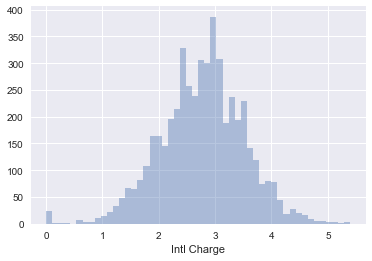

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(churn_df['Intl Charge'], kde=False)

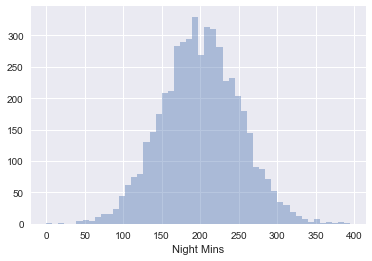

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(churn_df['Night Mins'], kde=False)

We can also take a few minutes to create a for loop to plot all columns, save this handy code for later EDA! Or we can use inbuilt pandas.dataframe.hist to do this more efficiently and to avoid unecessary memory use.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cdbbf50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d3e0c90>]], dtype=object)

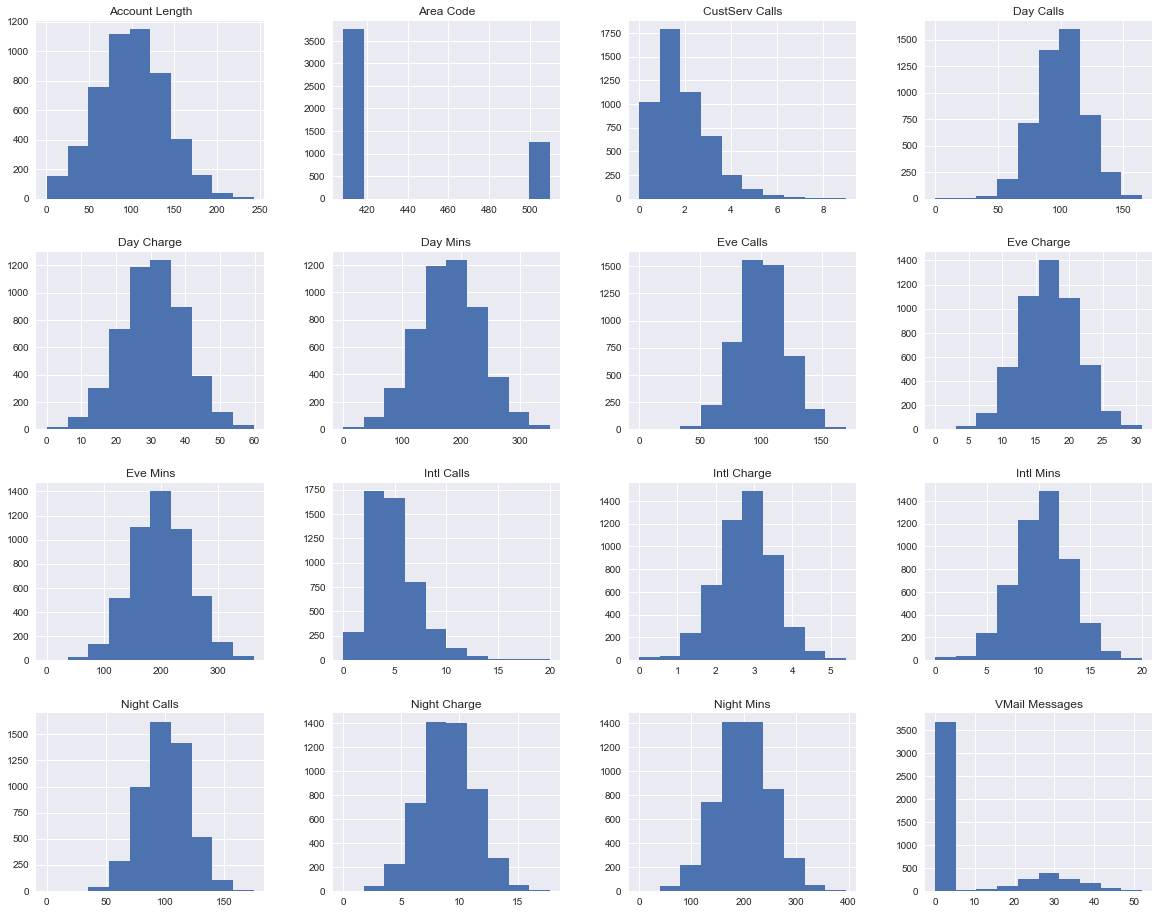

In [48]:
# %matplotlib notebook
# from itertools import combinations
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(len(churn_df.columns)//3, 3, figsize=(12, 48))

# i = 0
# for triaxis in axes:
#     for axis in triaxis:
#         churn_df.hist(column = churn_df.columns[i], bins = 100, ax=axis)
#         i = i+1
%matplotlib inline
import matplotlib.pyplot as plt

churn_df.hist(layout=(4,4), figsize=(20, 16))

Let's explore other angles exploring the correlation of variables will help remove any unnecesary explanatory variables.

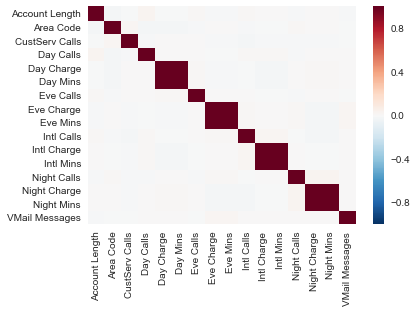

In [53]:
import seaborn as sb


corr = churn_df[['Account Length','Area Code','CustServ Calls','Day Calls','Day Charge','Day Mins','Eve Calls','Eve Charge','Eve Mins','Intl Calls','Intl Charge','Intl Mins','Night Calls','Night Charge','Night Mins','VMail Messages']].corr()

sb.heatmap(corr)

In [54]:
corr

,Account Length,Area Code,CustServ Calls,Day Calls,Day Charge,Day Mins,Eve Calls,Eve Charge,Eve Mins,Intl Calls,Intl Charge,Intl Mins,Night Calls,Night Charge,Night Mins,VMail Messages
Account Length,1.000000,-0.018054,-0.001445,0.028240,-0.001019,-0.001017,0.009143,-0.009587,-0.009591,0.014277,0.001292,0.001291,-0.007825,0.000656,0.000668,-0.014575
Area Code,-0.018054,1.000000,0.020921,-0.019314,-0.019119,-0.019118,-0.012300,0.007114,0.007098,-0.013623,-0.004219,-0.004154,0.014657,0.002070,0.002084,-0.003399
CustServ Calls,-0.001445,0.020921,1.000000,-0.010739,0.002726,0.002733,0.006235,-0.013836,-0.013823,-0.019147,-0.012180,-0.012122,-0.008283,-0.008530,-0.008533,-0.007086
Day Calls,0.028240,-0.019314,-0.010739,1.000000,0.001936,0.001935,0.003754,-0.000695,-0.000699,0.010893,0.013161,0.013097,-0.008308,0.002802,0.002804,0.000883
Day Charge,-0.001019,-0.019119,0.002726,0.001936,1.000000,1.000000,0.008129,-0.010757,-0.010747,-0.001307,-0.019419,-0.019490,0.004235,0.011785,0.011801,0.005377
Day Mins,-0.001017,-0.019118,0.002733,0.001935,1.000000,1.000000,0.008128,-0.010760,-0.010750,-0.001303,-0.019415,-0.019486,0.004236,0.011783,0.011799,0.005381
Eve Calls,0.009143,-0.012300,0.006235,0.003754,0.008129,0.008128,1.000000,0.002778,0.002763,0.005574,-0.007507,-0.007458,-0.013682,0.001799,0.001781,-0.003954
Eve Charge,-0.009587,0.007114,-0.013836,-0.000695,-0.010757,-0.010760,0.002778,1.000000,1.000000,0.008393,0.000155,0.000132,0.013422,-0.016652,-0.016649,0.019496
Eve Mins,-0.009591,0.007098,-0.013823,-0.000699,-0.010747,-0.010750,0.002763,1.000000,1.000000,0.008388,0.000159,0.000137,0.013420,-0.016642,-0.016639,0.019490
Intl Calls,0.014277,-0.013623,-0.019147,0.010893,-0.001307,-0.001303,0.005574,0.008393,0.008388,1.000000,0.016900,0.016791,-0.000156,-0.017182,-0.017214,0.000124


# Part 2: Feature Processing

In [56]:
churn_df.head()

,State,Account Length,Area Code,Phone,Intl Plan,VMail Plan,VMail Messages,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Before we can progress into modelling (ML) we need to spend some time ensuring our feature variables are in a "machine" format - i.e. T/F = 1/0 (binary), we will also need other encodings, boolean values, array representation. This is also the time to drop columns that lack explanatory power (significance), as well as seperating our "outcome" variable in a binary state.

In [59]:
# Get ground truth data
y = np.where(churn_df['Churn?'] == 'True.',1,0)

# Drop some useless columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["Intl Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Converts data frame to its Numpy-array representation.
X = churn_feat_space.as_matrix().astype(np.float)

In [60]:
X.shape

(5000, 17)

In [61]:
y.shape

(5000,)

Great, I now have a feature space X and a set of target values y (dependent and independent varaibles). They match in length, and our y is obviously our _column vector_ outcome/target variable! Now let's double check that our encodings are accurate

In [62]:
churn_feat_space.head()

,Account Length,Intl Plan,VMail Plan,VMail Messages,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [63]:
X

array([[ 128.  ,    0.  ,    1.  , ...,    3.  ,    2.7 ,    1.  ],
       [ 107.  ,    0.  ,    1.  , ...,    3.  ,    3.7 ,    1.  ],
       [ 137.  ,    0.  ,    0.  , ...,    5.  ,    3.29,    0.  ],
       ..., 
       [  61.  ,    0.  ,    0.  , ...,    4.  ,    3.67,    1.  ],
       [ 109.  ,    0.  ,    0.  , ...,    6.  ,    2.3 ,    0.  ],
       [  86.  ,    0.  ,    1.  , ...,   16.  ,    2.51,    0.  ]])

Great, our data is in an array format, let's scale it.

In [64]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 5000 observations and 17 features
Unique target labels: [0 1]


In [65]:
X

array([[ 0.69894149, -0.32324017,  1.66712012, ..., -0.58423577,
        -0.0955088 , -0.43667564],
       [ 0.16984882, -0.32324017,  1.66712012, ..., -0.58423577,
         1.24598231, -0.43667564],
       [ 0.92569549, -0.32324017, -0.5998368 , ...,  0.22991664,
         0.69597096, -1.20223603],
       ..., 
       [-0.98911606, -0.32324017, -0.5998368 , ..., -0.17715957,
         1.20573758, -0.43667564],
       [ 0.2202386 , -0.32324017, -0.5998368 , ...,  0.63699285,
        -0.63210525, -1.20223603],
       [-0.35924384, -0.32324017,  1.66712012, ...,  4.70775494,
        -0.35039211, -1.20223603]])

MUNGING COMPLETE!!! (This is typically much more complex, but we're working with a relatively sanatized raw dataset - thanks [UCI](https://archive.ics.uci.edu/ml/datasets.html)). Now onto the fun part: modelling!

One slight side note. Many predictors care about the relative size of different features even though those scales might be arbitrary. For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude larger than their win percentage. But this doesn't mean that the latter is 100 times less signifigant. StandardScaler fixes this by normalizing each feature to a range of around 1.0 to -1.0 thereby preventing models from misbehaving. Well, at least for that reason.

# Part 3: Model Training and Result Evaluation

## Part 3.1: K-fold Cross-Validation

Express, test, cycle. A machine learning pipeline should be anything but static. There are always new features to design, new data to use, new classifiers to consider each with unique parameters to tune. And for every change it's critical to be able to ask, "Is the new version better than the last?" So how do I do that?

As a good start, cross validation will be used throught this example. Cross validation attempts to avoid overfitting (training on and predicting the same datapoint) while still producing a prediction for each observation dataset. This is accomplished by systematically hiding different subsets of the data while training a set of models. After training, each model predicts on the subset that had been hidden to it, emulating multiple train-test splits. When done correctly, every observation will have a 'fair' corresponding prediction.

Here's what that looks like using scikit-learn libraries.

In [76]:
from sklearn.cross_validation import KFold

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True) #n_splits=5
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

## Part 3.2: Run Supervised Learning Models and Calculate Accuracy

Let's compare five fairly unique algorithms support vector machines, random forest, k-nearest-neighbors, gradient boosting, and logistic regression. Nothing too fancy here, just passing each to cross validation and determining how often the classifier predicted the correct class.

Our motivation for a classifier is relatively straightforward - we are predicting a binary outcome: churn: T|F ? Given we are trying to model and predict this yes/no outcome, decision trees prove advantageous - essentially we start from our outcome (churned or not) and trace backwards, finding as many common groupings as possible. 

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred) # NumPy interpretes True and False as 1. and 0.

LR_CV_result = run_cv(X,y,LogisticRegression)
RF_CV_result = run_cv(X,y,RandomForestClassifier)
KNN_CV_result = run_cv(X,y,KNeighborsClassifier) #Default: n_neighbors=5
SVC_CV_result = run_cv(X,y,SVC) #Default: n_neighbors=5
GBC_CV_result = run_cv(X,y,GBC) #Default: n_neighbors=5

In [81]:
def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

# print "Logistic Regression:"
# print "%.3f" % str(accuracy(y, run_cv(X,y,LR_CV_result)))
# print "Random Forest"
# print "%.3f" % accuracy(y, run_cv(X,y,RF_CV_result))
# print "K-nearest-neighbors:"
# print "%.3f" % accuracy(y, run_cv(X,y,KNN_CV_result))
# print "Support vector machine:"
# print "%.3f" % accuracy(y, run_cv(X,y,SVC_CV_result))
# print "Gradient Boosting:"
# print "%.3f" % accuracy(y, run_cv(X,y,GBC_CV_result))

print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result))
print "Random forest classifier: " + str(accuracy(y, RF_CV_result))
print "K-nearest-neighbors classifier: " + str(accuracy(y, KNN_CV_result))
print "Support vector machines classifier: " + str(accuracy(y, SVC_CV_result))
print "Gradient boosting classifier: " + str(accuracy(y, GBC_CV_result))

Logistic Regression (L2 is default): 0.8648
Random forest classifier: 0.9512
K-nearest-neighbors classifier: 0.9006
Support vector machines classifier: 0.927
Gradient boosting classifier: 0.9544


Based on the above, we can simply choose the model with the greatest accuracy, correct? In our case Gradient Boosting Classifier is our choice, correct? Or should we also consider other measures, such as precision?

In [98]:
![alt text](precision_accuracy.png "Precision vs Accuracy")

/bin/sh: -c: line 0: syntax error near unexpected token `('
/bin/sh: -c: line 0: `[alt text](precision_accuracy.png "Precision vs Accuracy")'


In [82]:
LR_CV_result

array([0, 0, 0, ..., 0, 0, 0])

Let's see the prediction results...

In [84]:
#Show the details of prediction results
churn_df_LR_CV = churn_df
churn_df_LR_CV['LR_Predicted_churned'] = LR_CV_result == 1
churn_df_LR_CV[churn_df_LR_CV.columns[-2:]].head(11)

,Churn?,LR_Predicted_churned
0,False.,False
1,False.,False
2,False.,False
3,False.,True
4,False.,False
5,False.,False
6,False.,False
7,False.,False
8,False.,False
9,False.,False


## Part 3.3: Use Grid Search to Find Optimal Parameters 

### Part 3.3.1: Find Optimal Parameters - LogisticRegression

In [106]:
def print_grid_search_metrics(gs):
    print "Best score: %0.3f" % gs.best_score_
    print "Best parameters set:"
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [107]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5, verbose=1, refit=False)
Grid_LR.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [108]:
print_grid_search_metrics(Grid_LR)

Best score: 0.865
Best parameters set:
	C: 1
	penalty: 'l1'


In [109]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(LogisticRegression(C=1,penalty='l1'), X, y, cv=5)
print "Logistic Regression 5-fold cross validation accuracy: " + str(np.mean(score))

Logistic Regression 5-fold cross validation accuracy: 0.865201691802


### Part 3.3.2: Find Optimal Parameters: KNN

In [110]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5, verbose=1, refit=False)
Grid_KNN.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=False, scoring=None, verbose=1)

In [111]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.900
Best parameters set:
	n_neighbors: 5


In [112]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(KNeighborsClassifier(n_neighbors=5),X,y,cv=5)
print "5-fold cross validation accuracy: " + str(np.mean(score))

5-fold cross validation accuracy: 0.900402120602


### Part 3.3.3: Find Optimal Parameters: RF

In [113]:
from sklearn.grid_search import GridSearchCV
parameters = {
    'n_neighbors':[3,5,7,10] 
}

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

Grid_RF = GridSearchCV(RandomForestClassifier(),param_grid=param_grid, cv= 5)
Grid_RF.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'criterion': ['gini', 'entropy'], 'max_features': [1, 3, 10], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [114]:
print_grid_search_metrics(Grid_RF)

Best score: 0.957
Best parameters set:


KeyError: 'n_neighbors'

In [105]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), X,y,cv= 5)
print "RF validation accuracy: " + str(np.mean(score))

RF validation accuracy: 0.9490001602


In [97]:
# def print_grid_search_metrics(gs):
#     print "Best score: %0.3f" % gs.best_score_
#     print "Best parameters set:"
#     best_parameters = gs.best_params_
#     for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_grid]))


print_grid_search_metrics(Grid_RF)

Best score: 0.957
Best parameters set:


TypeError: unhashable type: 'dict'